### Learning trajectory analysis 

##### Look at time trends and analyze various metrics of perforamance and strategy based evaluation methods 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from IPython.display import display, HTML

In [12]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/code/utils')
import behavior_utils as bu
import array_utils as au


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load in local csv
folder = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv'
df = pd.read_csv(folder)

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_6551/1731727521.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder)


In [14]:
# Check dimensions and content of dataframe for variables of interest: 

ids = df['subject_id'].unique()
num_stage = df['current_stage_actual'].unique()
stages = df['current_stage_actual']
forag_eff_count = df['foraging_eff']
task_count = df['task'].unique()
session_count = df['session'].unique()

print(f'Maximum number of sessions for any given subject: {len(session_count)}')
print(f'\nTypes of tasks: {task_count}, \n Number of unique tasks: {len(task_count)}')
print(f'\n Number of subjects: {len(ids)}')
print(f'\n Types of stages: {num_stage}')
print(f'\n Number of forag efficiency scores: {len(forag_eff_count)}')

Maximum number of sessions for any given subject: 69

Types of tasks: ['Uncoupled Baiting' 'RewardN' 'Coupled Baiting' 'Coupled Without Baiting'
 'Uncoupled Without Baiting'], 
 Number of unique tasks: 5

 Number of subjects: 397

 Types of stages: ['GRADUATED' 'STAGE_FINAL' nan 'STAGE_2' 'STAGE_1' 'STAGE_3'
 'STAGE_1_WARMUP' 'STAGE_4']

 Number of forag efficiency scores: 9083


In [15]:
# New features: 
# curriculum_version, water_**, effective_block_**, duration_delay_period_**, 
# duration_iti_**, lickspout_movement_**, reward_vol_**, curriculum_schema_version, 
# autowater, finished_rate, bias_naive, reaction_time, early_lick_rate, double_dipping_rate_**,
# lick_consistency_mean_**, weekday, 

##### Preprocessing

In [17]:
# Drop warmup stage 
df = df[df['current_stage_actual'] !='STAGE_1_WARMUP']

# Drop outlier subjects
df = bu.filter_by_group_size(df, category_col='current_stage_actual', category_max=20)


In [18]:
# Check size comparison (original = 730080)
print(df.size)

447109


##### DataFrame Splits

In [19]:
# Create stage and stage/task DataFrames

main_df = df[['subject_id', 'current_stage_actual','session', 'subject_genotype', 'foraging_eff', 'foraging_performance', 'foraging_eff_random_seed']]

main_task_df = df[['subject_id', 'current_stage_actual','session','task', 'subject_genotype', 'foraging_eff', 'foraging_performance', 'foraging_eff_random_seed']]

In [20]:
# Fix stage order problem

stage_vector = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_4', 'STAGE_FINAL', 'GRADUATED']

task_vector = ['Uncoupled Without Baiting', 'Coupled Baiting', 'Coupled Without Baiting', 'Uncoupled Baiting']

# Make explicit copy 
main_df = main_df.copy()
main_task_df = main_task_df.copy()


main_df['current_stage_actual'] = pd.Categorical(main_df['current_stage_actual'], categories=stage_vector)

main_task_df['current_stage_actual'] = pd.Categorical(main_task_df['current_stage_actual'], categories=stage_vector)
main_task_df['task'] = pd.Categorical(main_task_df['task'], categories=task_vector)

In [21]:
main_df.head()

,subject_id,current_stage_actual,session,subject_genotype,foraging_eff,foraging_performance,foraging_eff_random_seed
2,728568,GRADUATED,31.0,Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9),0.802109,0.751498,0.780059
3,745505,STAGE_FINAL,11.0,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,0.779864,0.677290,0.804054
4,745502,STAGE_FINAL,15.0,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,0.615341,0.588481,0.643110
5,746896,STAGE_FINAL,11.0,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,0.823828,0.813324,0.824405
6,764788,NaN,6.0,wt/wt,0.336676,0.274533,0.326389


In [22]:
main_task_df

,subject_id,current_stage_actual,session,task,subject_genotype,foraging_eff,foraging_performance,foraging_eff_random_seed
2,728568,GRADUATED,31.0,Uncoupled Baiting,Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9),0.802109,0.751498,0.780059
3,745505,STAGE_FINAL,11.0,Uncoupled Baiting,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,0.779864,0.677290,0.804054
4,745502,STAGE_FINAL,15.0,Uncoupled Baiting,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,0.615341,0.588481,0.643110
5,746896,STAGE_FINAL,11.0,Uncoupled Baiting,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,0.823828,0.813324,0.824405
6,764788,NaN,6.0,NaN,wt/wt,0.336676,0.274533,0.326389
...,...,...,...,...,...,...,...,...
4358,703548,STAGE_2,4.0,Coupled Baiting,NaN,0.828273,0.677678,0.863309
4369,704151,STAGE_1,1.0,Coupled Baiting,NaN,0.568513,0.172584,0.619048
4378,703548,STAGE_1,3.0,Coupled Baiting,NaN,0.801282,0.594106,0.811688
4385,703548,STAGE_1,2.0,Coupled Baiting,NaN,0.704148,0.432306,0.745665


##### Splitting

Threshold value: 8.25 sessions
Number of slow learners 42
Number of fast learners 80


<Figure size 1200x600 with 0 Axes>

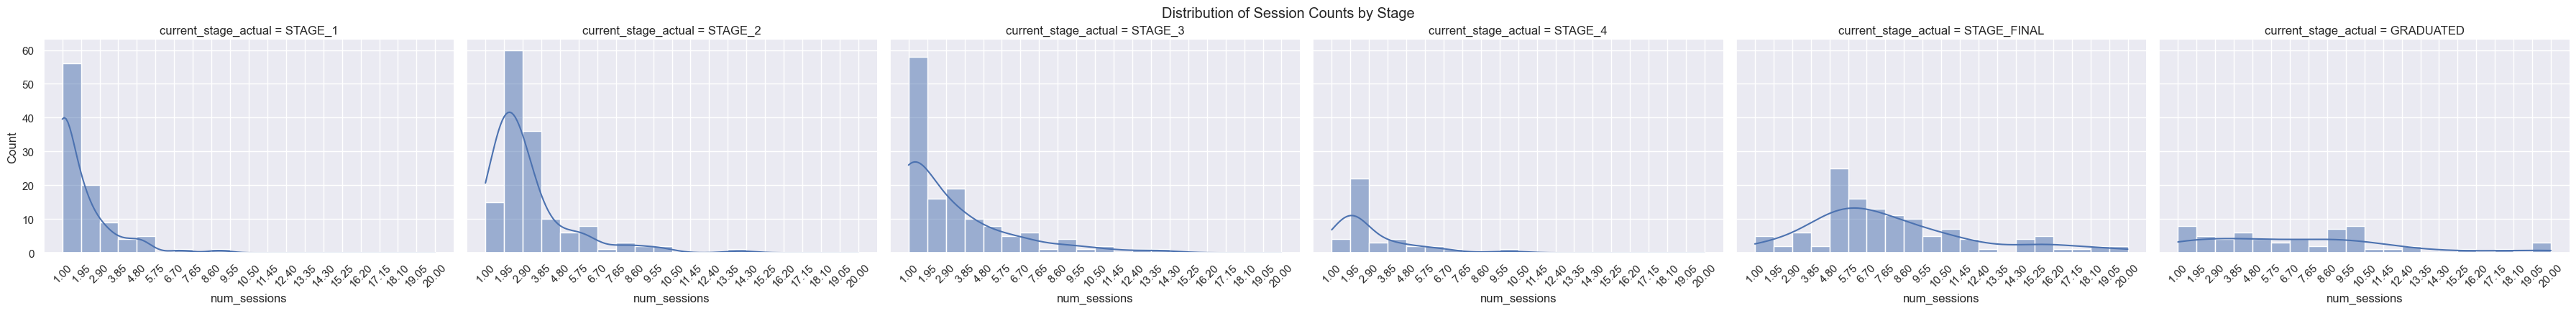

<Figure size 1200x600 with 0 Axes>

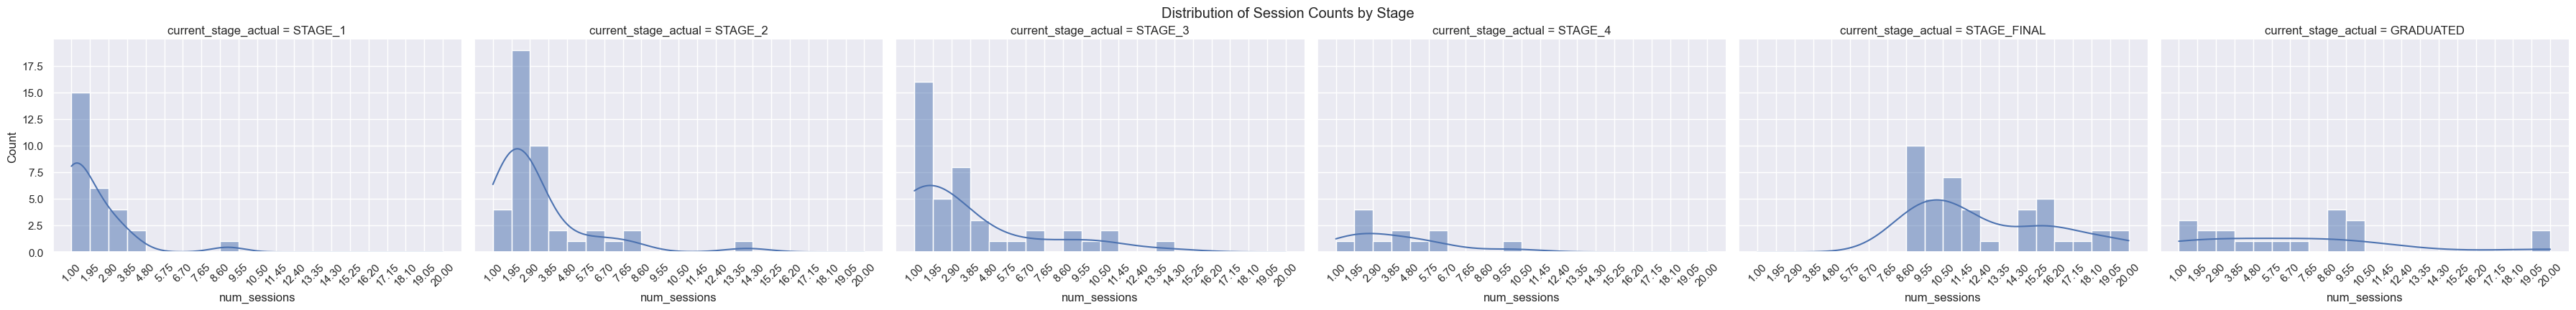

<Figure size 1200x600 with 0 Axes>

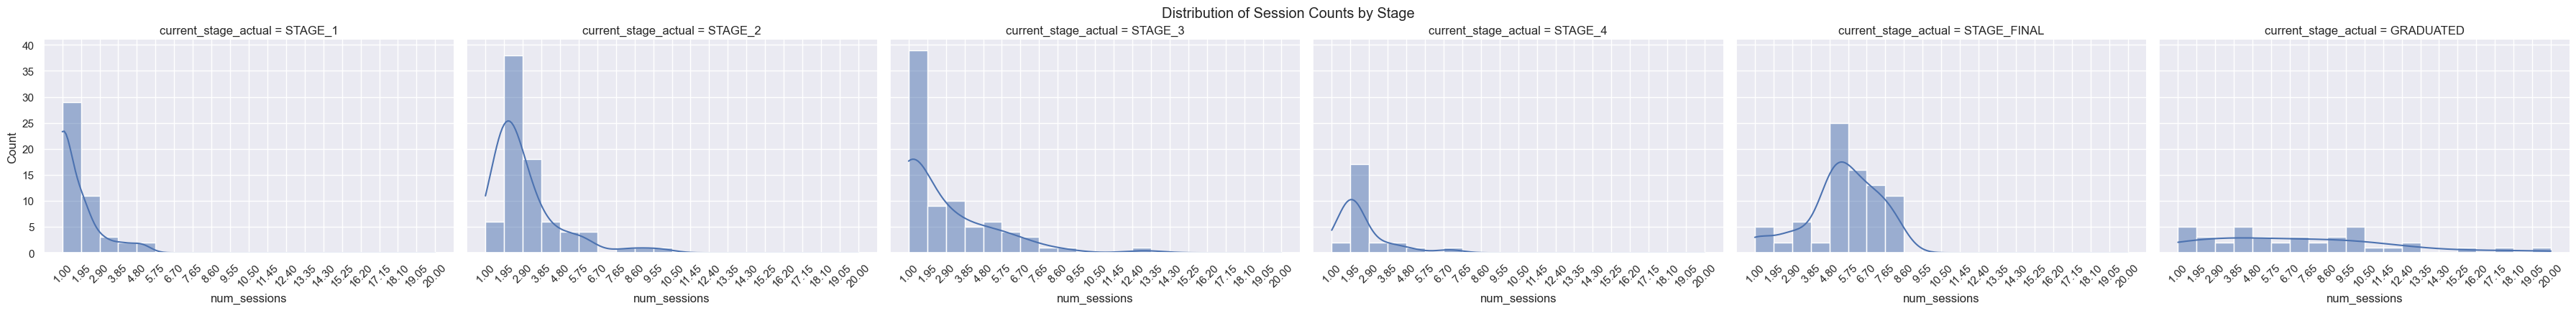

In [23]:
# Pass function to stage only DataFrame

sns.set_theme()
main_results = bu.analyze_splits(main_df, threshold = 8.25)
fast_session_main_df = main_results['fast']['df']
slow_session_main_df = main_results['slow']['df']
threshold_used = main_results['threshold']

Threshold value: 8.25 sessions
Number of slow learners 40
Number of fast learners 82


<Figure size 1200x600 with 0 Axes>

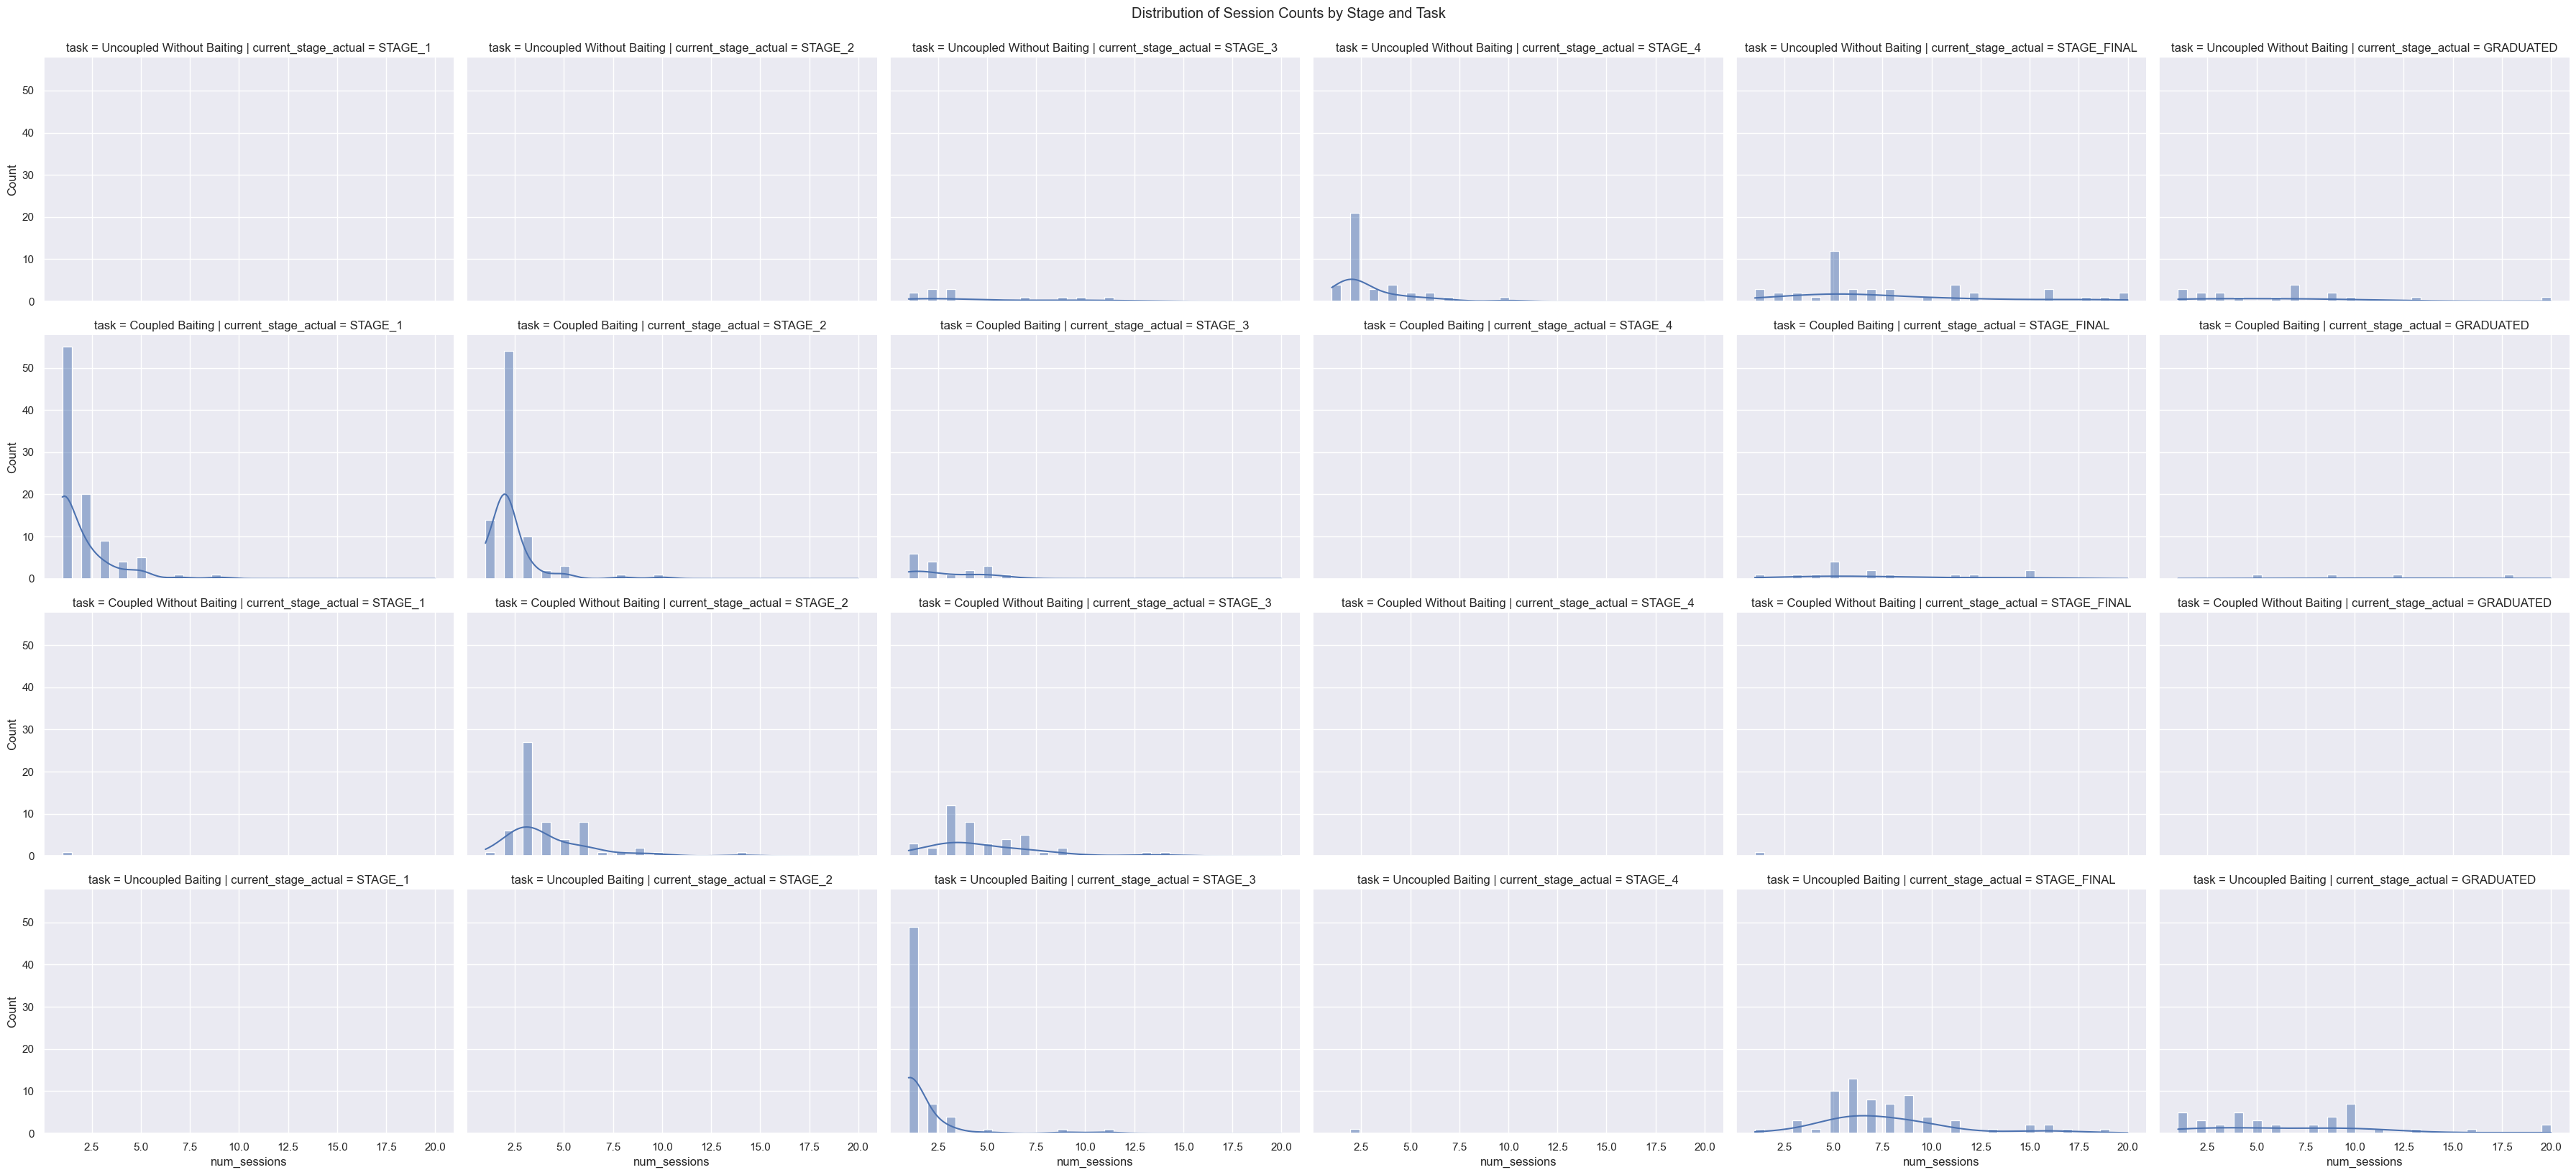

<Figure size 1200x600 with 0 Axes>

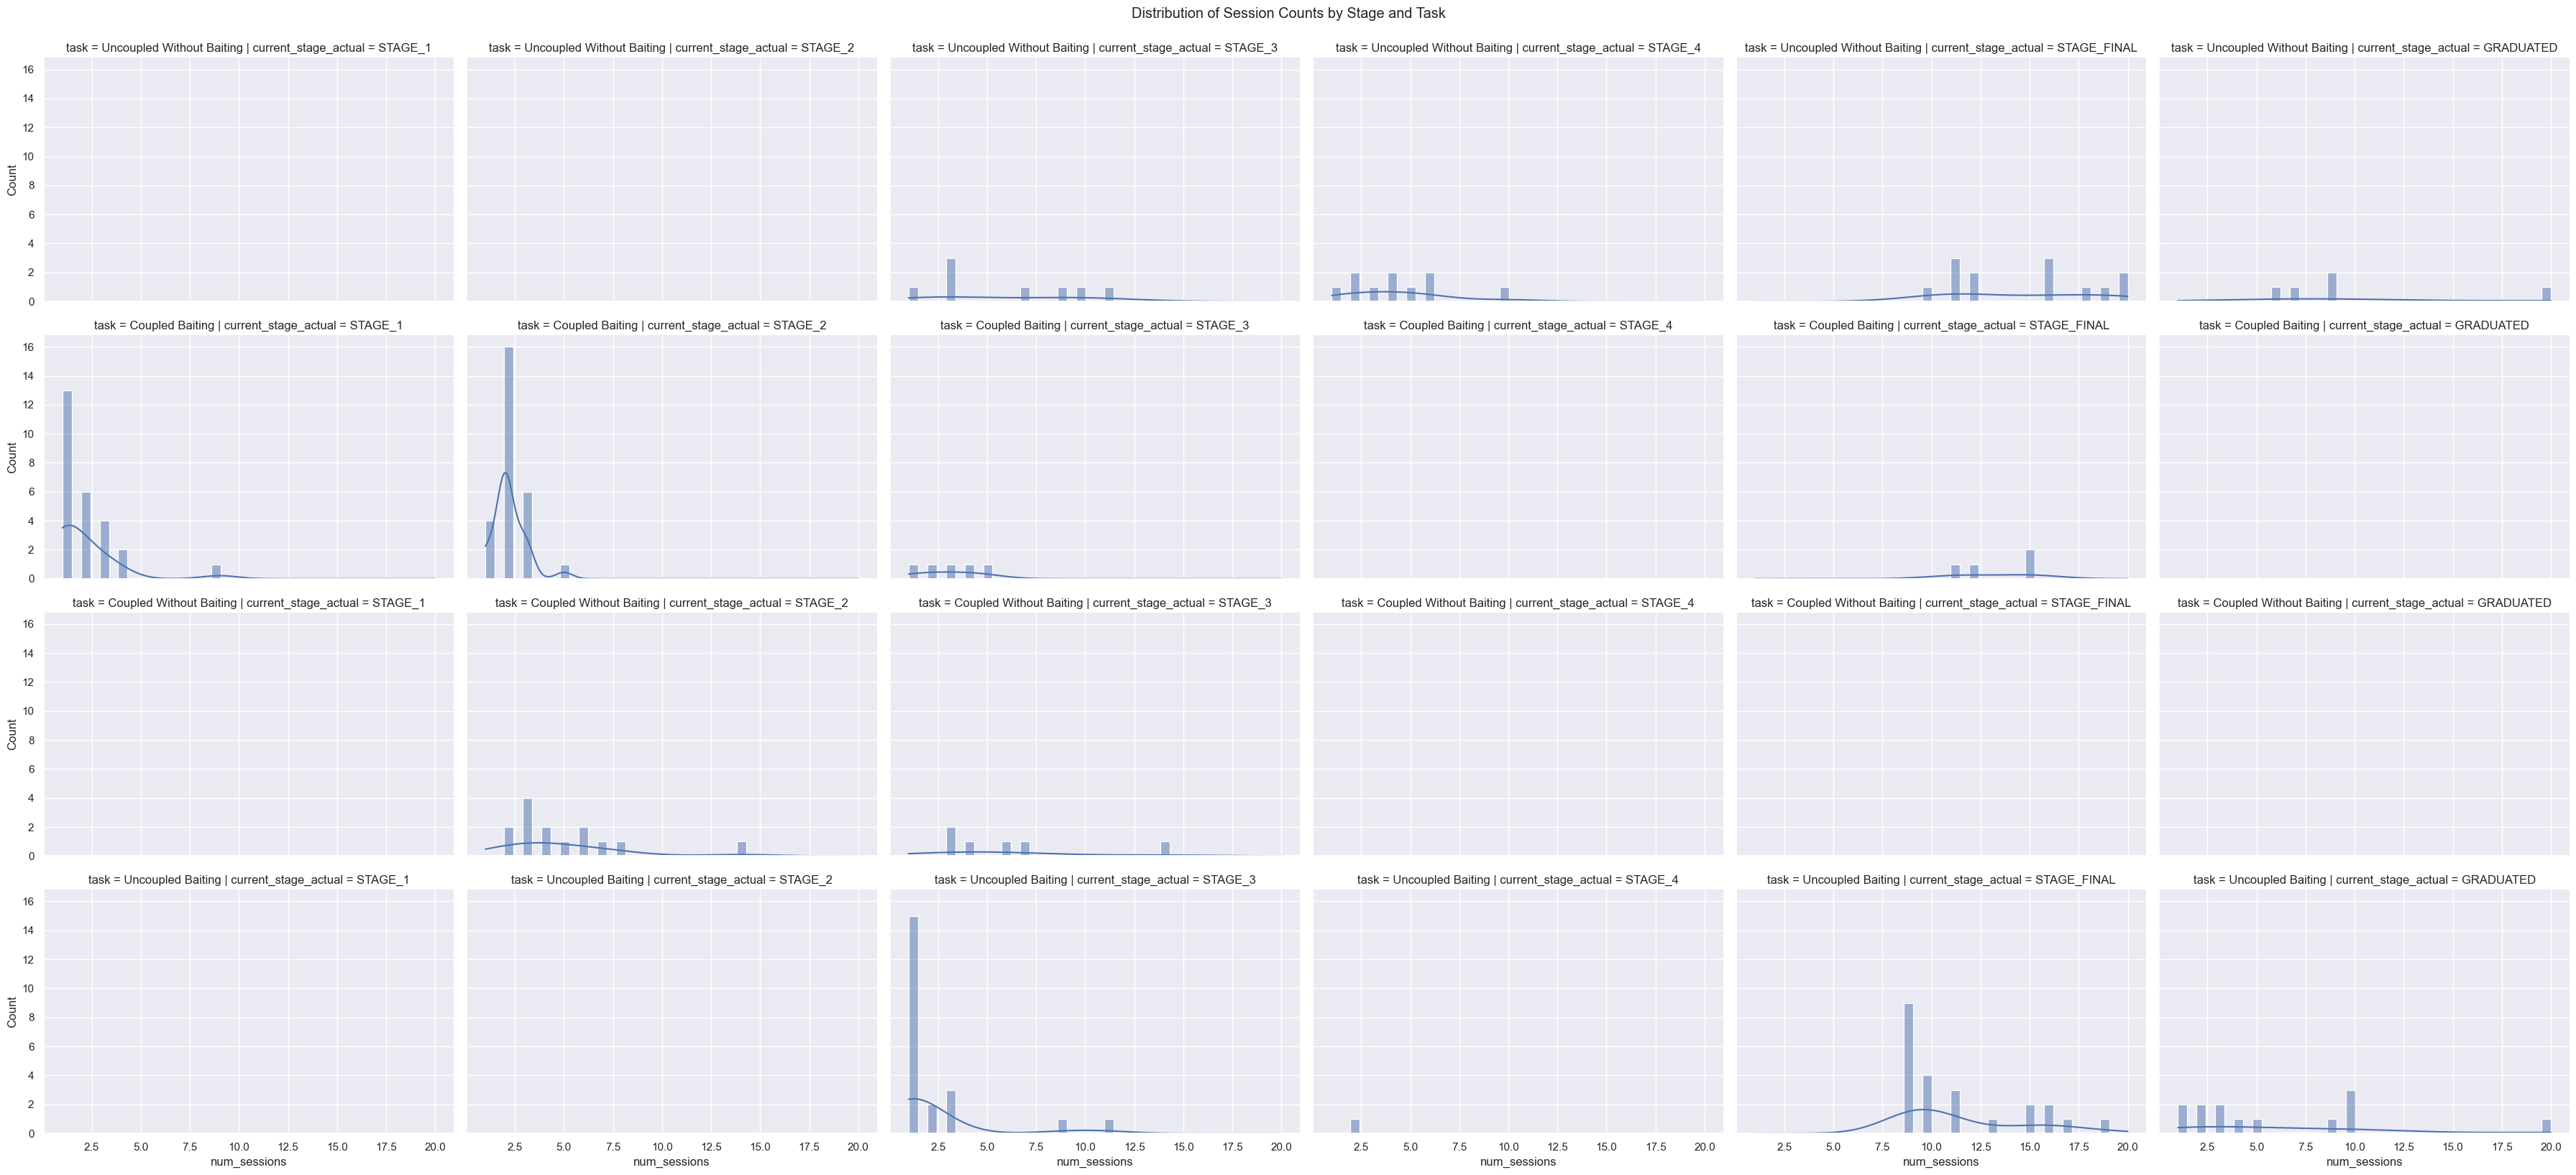

<Figure size 1200x600 with 0 Axes>

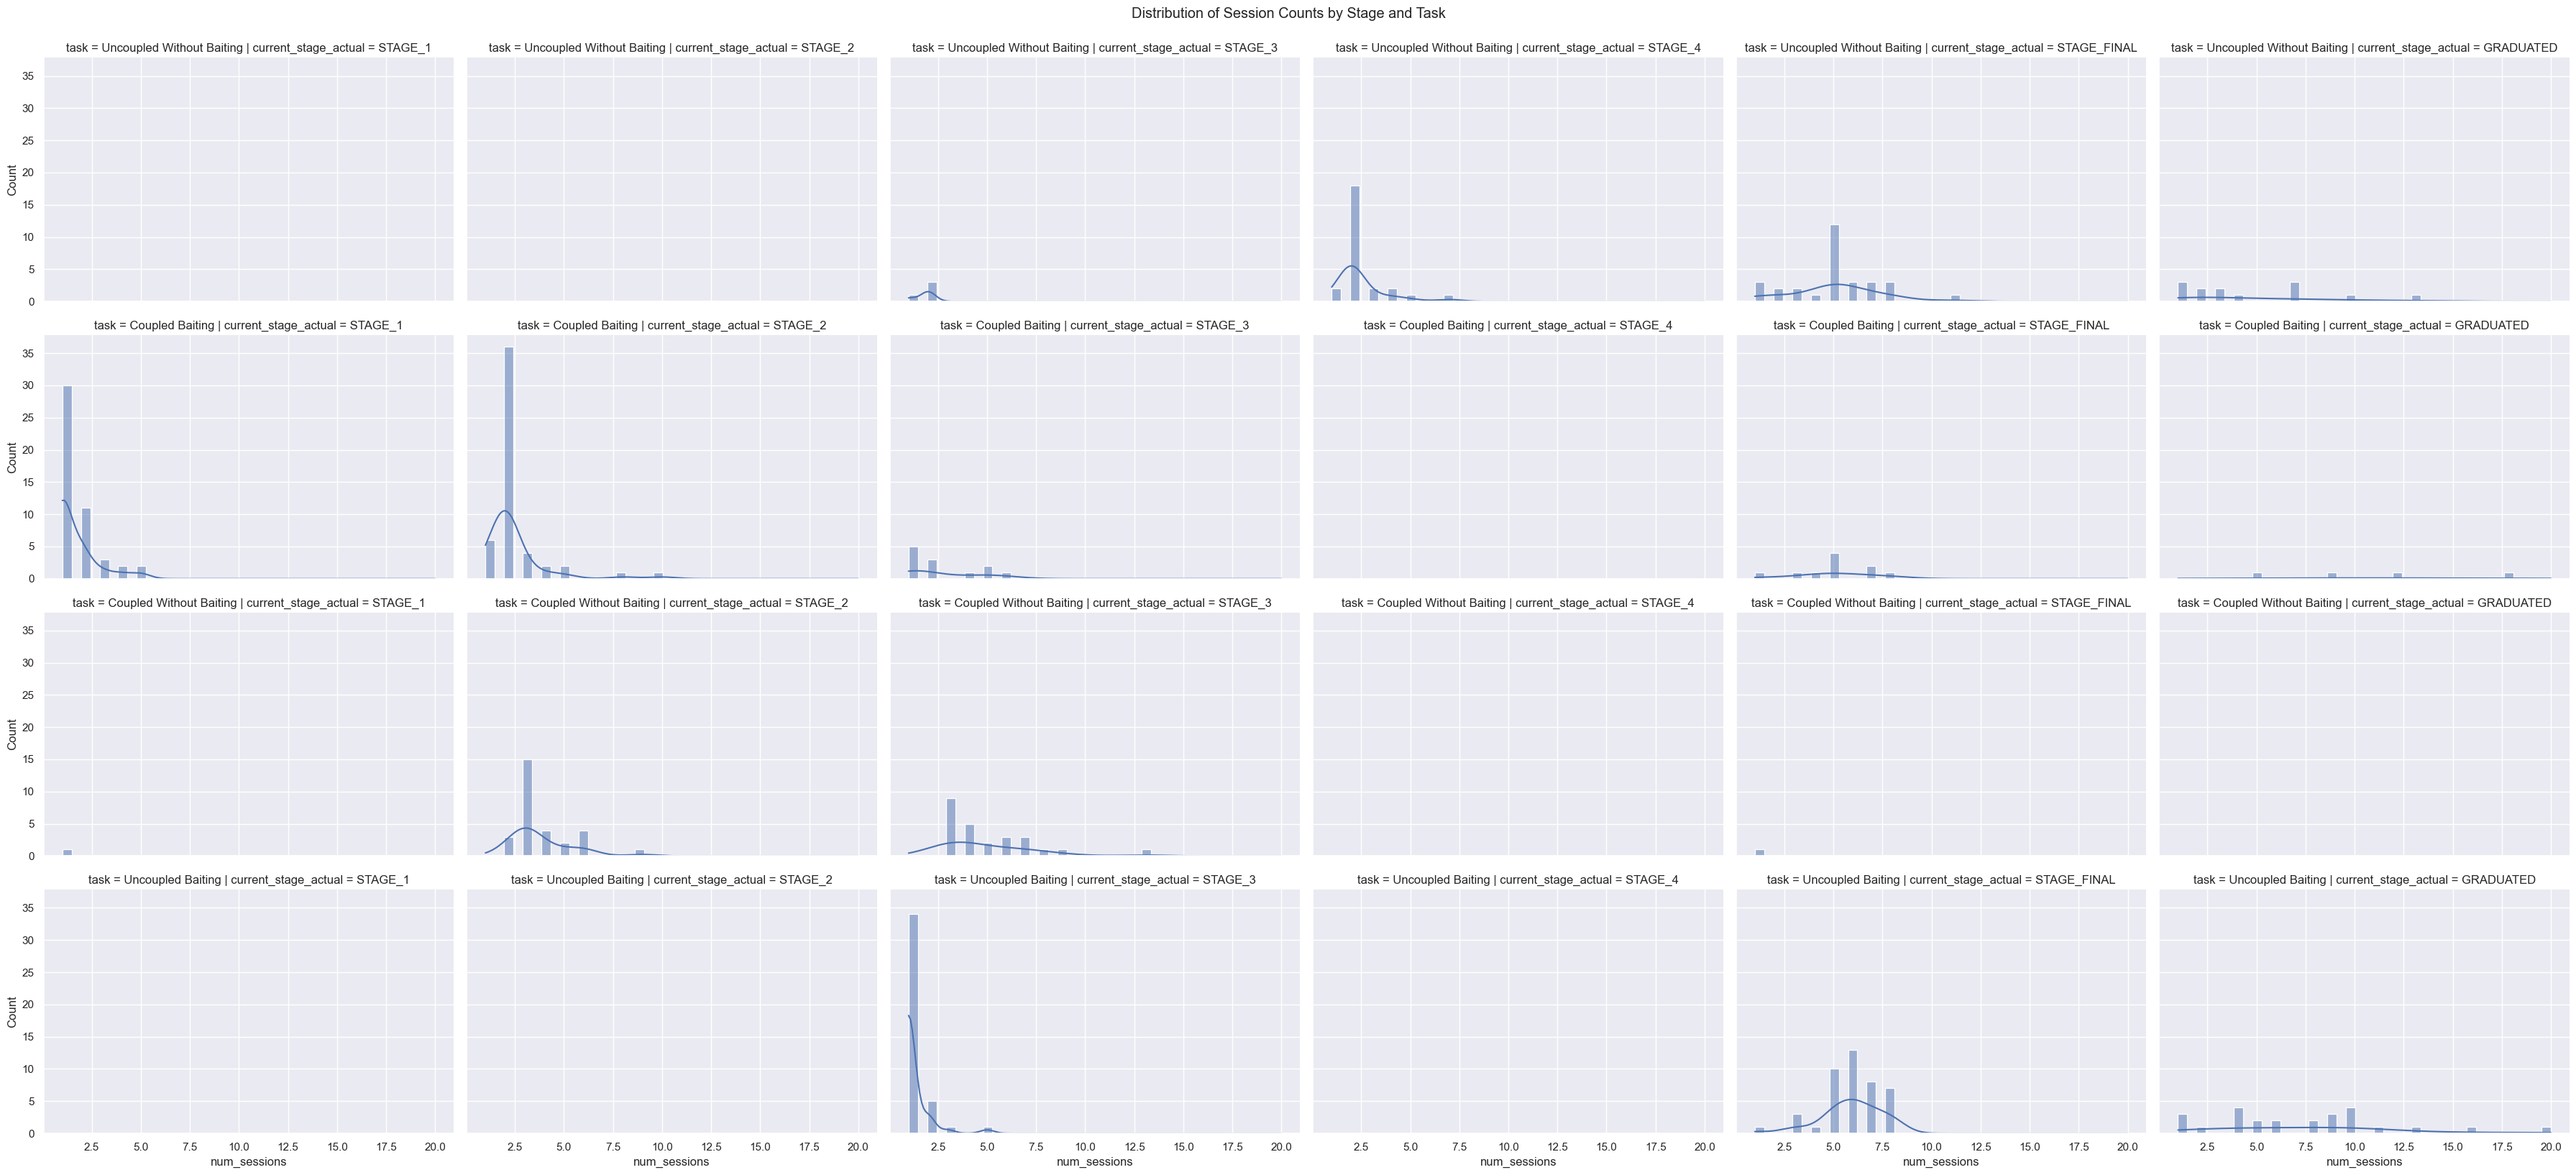

In [24]:
task_results = bu.analyze_splits(main_task_df, task_col='task', threshold = 8.25)

slow_session_task_df = task_results['slow']['df']
fast_session_task_df = task_results['fast']['df']

In [25]:
# Create design matrices for all task types, and show sumnmary stats
slow_stage_arrays = au.create_arrays(slow_session_main_df, task_col=None)
au.summary_statistics(slow_stage_arrays)

No data found for nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,GRADUATED,N/A,"(42, 20)",3.357143,5.130773,0,20,0
1,STAGE_FINAL,N/A,"(42, 20)",12.642857,3.462874,9,20,0
2,STAGE_3,N/A,"(42, 14)",3.595238,3.352750,1,14,0
3,STAGE_2,N/A,"(42, 14)",3.190476,2.412646,1,14,0
4,STAGE_1,N/A,"(42, 9)",1.333333,1.642685,0,9,0
5,STAGE_4,N/A,"(42, 10)",1.119048,2.195259,0,10,0


In [26]:
fast_stage_arrays = au.create_arrays(fast_session_main_df, task_col=None)
au.summary_statistics(fast_stage_arrays)

No data found for nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_FINAL,N/A,"(80, 8)",5.4375,1.856366,1,8,0
1,GRADUATED,N/A,"(80, 20)",3.5125,4.842504,0,20,0
2,STAGE_2,N/A,"(80, 10)",2.8875,1.724774,0,10,0
3,STAGE_4,N/A,"(80, 7)",0.7750,1.350694,0,7,0
4,STAGE_3,N/A,"(80, 13)",2.6500,2.340406,0,13,0
5,STAGE_1,N/A,"(80, 5)",0.9750,1.150815,0,5,0


In [27]:
# Create design matrices for all task / stage combinations
slow_stage_task_arrays = au.create_arrays(slow_session_task_df)
au.summary_statistics(slow_stage_task_arrays)

No data found for GRADUATED and Coupled Baiting
No data found for GRADUATED and Coupled Without Baiting
No data found for STAGE_FINAL and Coupled Without Baiting
No data found for STAGE_2 and Uncoupled Baiting
No data found for STAGE_2 and Uncoupled Without Baiting
No data found for STAGE_1 and Uncoupled Baiting
No data found for STAGE_1 and Uncoupled Without Baiting
No data found for STAGE_1 and Coupled Without Baiting
No data found for nan and Uncoupled Baiting
No data found for nan and Coupled Baiting
No data found for nan and Uncoupled Without Baiting
No data found for nan and Coupled Without Baiting
No data found for STAGE_4 and Coupled Baiting
No data found for STAGE_4 and Coupled Without Baiting


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,GRADUATED,Uncoupled Baiting,"(40, 20)",2.000,4.153312,0,20,0
1,GRADUATED,Uncoupled Without Baiting,"(40, 20)",1.275,3.814364,0,20,0
2,STAGE_FINAL,Uncoupled Baiting,"(40, 19)",6.625,6.159089,0,19,0
3,STAGE_FINAL,Coupled Baiting,"(40, 15)",1.325,4.014894,0,15,0
4,STAGE_FINAL,Uncoupled Without Baiting,"(40, 20)",4.800,7.215262,0,20,0
5,STAGE_3,Uncoupled Baiting,"(40, 11)",1.200,2.204541,0,11,2
6,STAGE_3,Coupled Baiting,"(40, 5)",0.375,1.111024,0,5,0
7,STAGE_3,Uncoupled Without Baiting,"(40, 11)",1.175,2.845062,0,11,0
8,STAGE_3,Coupled Without Baiting,"(40, 14)",0.925,2.649410,0,14,0
9,STAGE_2,Coupled Baiting,"(40, 5)",1.475,1.224490,0,5,0


In [28]:
fast_stage_task_arrays = au.create_arrays(fast_session_task_df)
au.summary_statistics(fast_stage_task_arrays)

No data found for GRADUATED and Coupled Without Baiting
No data found for STAGE_2 and Uncoupled Baiting
No data found for STAGE_2 and Uncoupled Without Baiting
No data found for nan and Uncoupled Baiting
No data found for nan and Uncoupled Without Baiting
No data found for nan and Coupled Without Baiting
No data found for nan and Coupled Baiting
No data found for STAGE_4 and Uncoupled Baiting
No data found for STAGE_4 and Coupled Without Baiting
No data found for STAGE_4 and Coupled Baiting
No data found for STAGE_1 and Uncoupled Baiting
No data found for STAGE_1 and Uncoupled Without Baiting


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_FINAL,Uncoupled Baiting,"(82, 8)",3.097561,3.153046,0,8,0
1,STAGE_FINAL,Uncoupled Without Baiting,"(82, 11)",1.841463,2.782653,0,11,0
2,STAGE_FINAL,Coupled Without Baiting,"(82, 1)",0.012195,0.109756,0,1,1
3,STAGE_FINAL,Coupled Baiting,"(82, 8)",0.609756,1.772115,0,8,0
4,GRADUATED,Uncoupled Baiting,"(82, 20)",2.268293,4.259992,0,20,0
5,GRADUATED,Uncoupled Without Baiting,"(82, 13)",0.743902,2.251346,0,13,0
6,GRADUATED,Coupled Baiting,"(82, 18)",0.536585,2.590767,0,18,4
7,STAGE_2,Coupled Without Baiting,"(82, 9)",1.341463,2.031577,0,9,0
8,STAGE_2,Coupled Baiting,"(82, 10)",1.536585,1.705051,0,10,0
9,STAGE_4,Uncoupled Without Baiting,"(82, 7)",0.780488,1.343679,0,7,0


In [29]:
# Set prefrence for outlier removal 

n = 1
n1 = 1

# Adjust outliers in each stage
# Non-task specific dict 
slow_filtered_arrays = au.remove_outliers_n(slow_stage_arrays, n)
fast_filtered_arrays = au.remove_outliers_n(fast_stage_arrays, n)

# Task specific dict
slow_filtered_task_arrays = au.remove_outliers_n(slow_stage_task_arrays, n1)
fast_filtered_task_arrays = au.remove_outliers_n(fast_stage_task_arrays, n1)

In [30]:
# Create heatmap for visualization of an example array in stage only dictionary 

def plot_array_heatmap(array, stage):
    plt.figure(figsize=(16,5))
    plt.imshow(array, cmap='viridis', aspect='auto')
    plt.colorbar(label='Foraging Efficiency')
    plt.title(f'Foraging Efficiency Heatmap for {stage}')
    plt.xlabel('Session Index')
    plt.ylabel('Subject Index')
    plt.show()

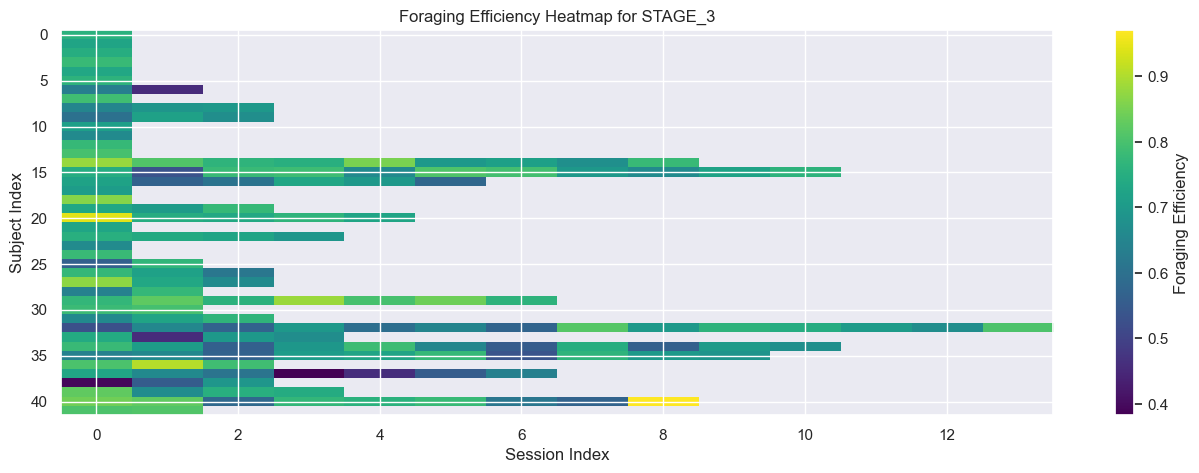

In [31]:
plot_array_heatmap(slow_stage_arrays['STAGE_3'], 'STAGE_3')

In [32]:
stage_averages = au.calculate_average_vectors(slow_stage_arrays)
stage_task_averages = au.calculate_average_vectors(fast_stage_arrays)


Average foraging efficiency for stage GRADUATED:
Average vector: [0.72187175 0.73453316 0.7509129  0.74302037 0.7321483  0.72308782
 0.73340637 0.73320365 0.7657958  0.79316633 0.79572581 0.76157171
 0.7267611  0.80060569 0.63496414 0.73338976 0.72081498 0.80621518
 0.76824234 0.70760653]
Shape: (20,)

Average foraging efficiency for stage STAGE_FINAL:
Average vector: [0.76769499 0.74426019 0.74491348 0.75600671 0.76436666 0.75607735
 0.73441991 0.73220537 0.73318697 0.76428907 0.7508361  0.70660767
 0.74347784 0.74458215 0.72271303 0.74801972 0.73812601 0.70801782
 0.77742571 0.60848542]
Shape: (20,)

Average foraging efficiency for stage STAGE_3:
Average vector: [0.73397202 0.70095352 0.68529792 0.7136228  0.70583154 0.70356731
 0.6486982  0.71205577 0.72981754 0.71856491 0.72877296 0.70601852
 0.67132538 0.80672022]
Shape: (14,)

Average foraging efficiency for stage STAGE_2:
Average vector: [0.73947861 0.72425331 0.70993709 0.69376095 0.64188615 0.64878886
 0.6787775  0.66560994 0

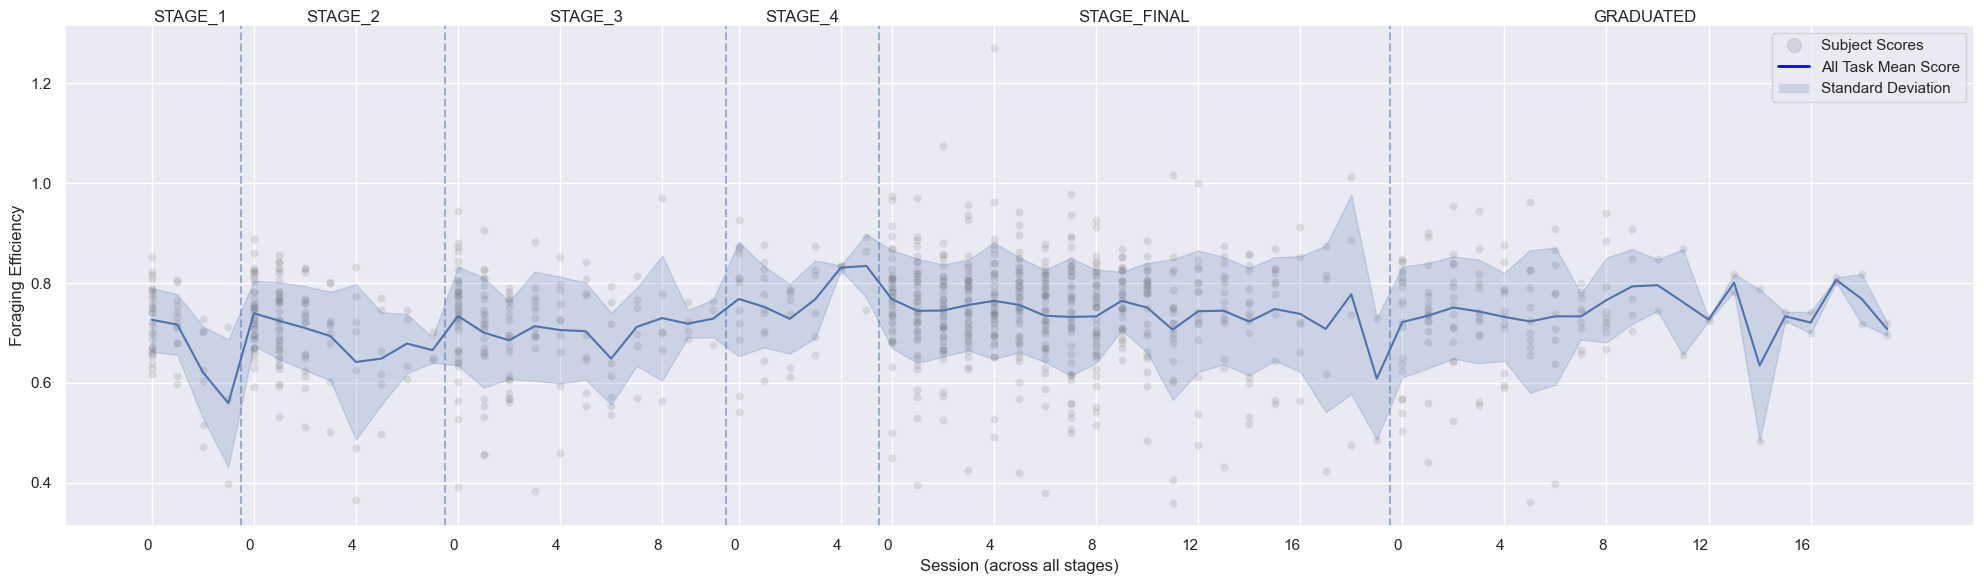


Statistics for All Tasks:

STAGE_1:
Number of Sessions: 4
Mean Foraging Efficiency: 0.66
Standard deviation: 0.08
Min efficiency: 0.56
Max efficiency: 0.73

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.69
Standard deviation: 0.04
Min efficiency: 0.64
Max efficiency: 0.74

STAGE_3:
Number of Sessions: 11
Mean Foraging Efficiency: 0.71
Standard deviation: 0.02
Min efficiency: 0.65
Max efficiency: 0.73

STAGE_4:
Number of Sessions: 6
Mean Foraging Efficiency: 0.78
Standard deviation: 0.04
Min efficiency: 0.73
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 20
Mean Foraging Efficiency: 0.74
Standard deviation: 0.04
Min efficiency: 0.61
Max efficiency: 0.78

GRADUATED:
Number of Sessions: 20
Mean Foraging Efficiency: 0.74
Standard deviation: 0.04
Min efficiency: 0.63
Max efficiency: 0.81


In [33]:
# Plot function for foraging efficiency over stages 

# Plot slow learners stage only
au.plot_metric(slow_filtered_arrays, stage_vector)

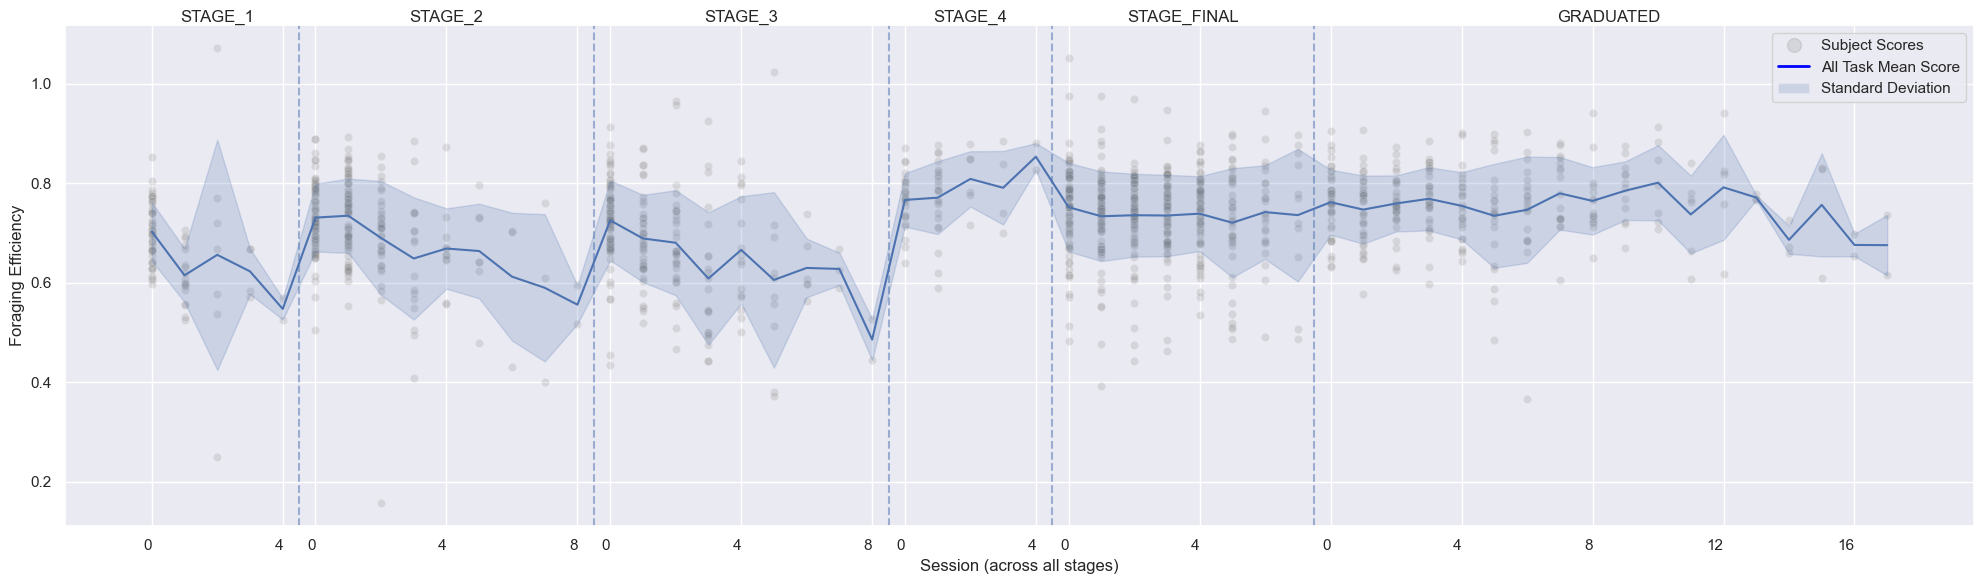


Statistics for All Tasks:

STAGE_1:
Number of Sessions: 5
Mean Foraging Efficiency: 0.63
Standard deviation: 0.06
Min efficiency: 0.55
Max efficiency: 0.70

STAGE_2:
Number of Sessions: 9
Mean Foraging Efficiency: 0.65
Standard deviation: 0.06
Min efficiency: 0.56
Max efficiency: 0.73

STAGE_3:
Number of Sessions: 9
Mean Foraging Efficiency: 0.64
Standard deviation: 0.07
Min efficiency: 0.49
Max efficiency: 0.73

STAGE_4:
Number of Sessions: 5
Mean Foraging Efficiency: 0.80
Standard deviation: 0.04
Min efficiency: 0.77
Max efficiency: 0.85

STAGE_FINAL:
Number of Sessions: 8
Mean Foraging Efficiency: 0.74
Standard deviation: 0.01
Min efficiency: 0.72
Max efficiency: 0.75

GRADUATED:
Number of Sessions: 18
Mean Foraging Efficiency: 0.75
Standard deviation: 0.04
Min efficiency: 0.68
Max efficiency: 0.80


In [34]:
# Plot fast learners stage only
au.plot_metric(fast_filtered_arrays, stage_vector)

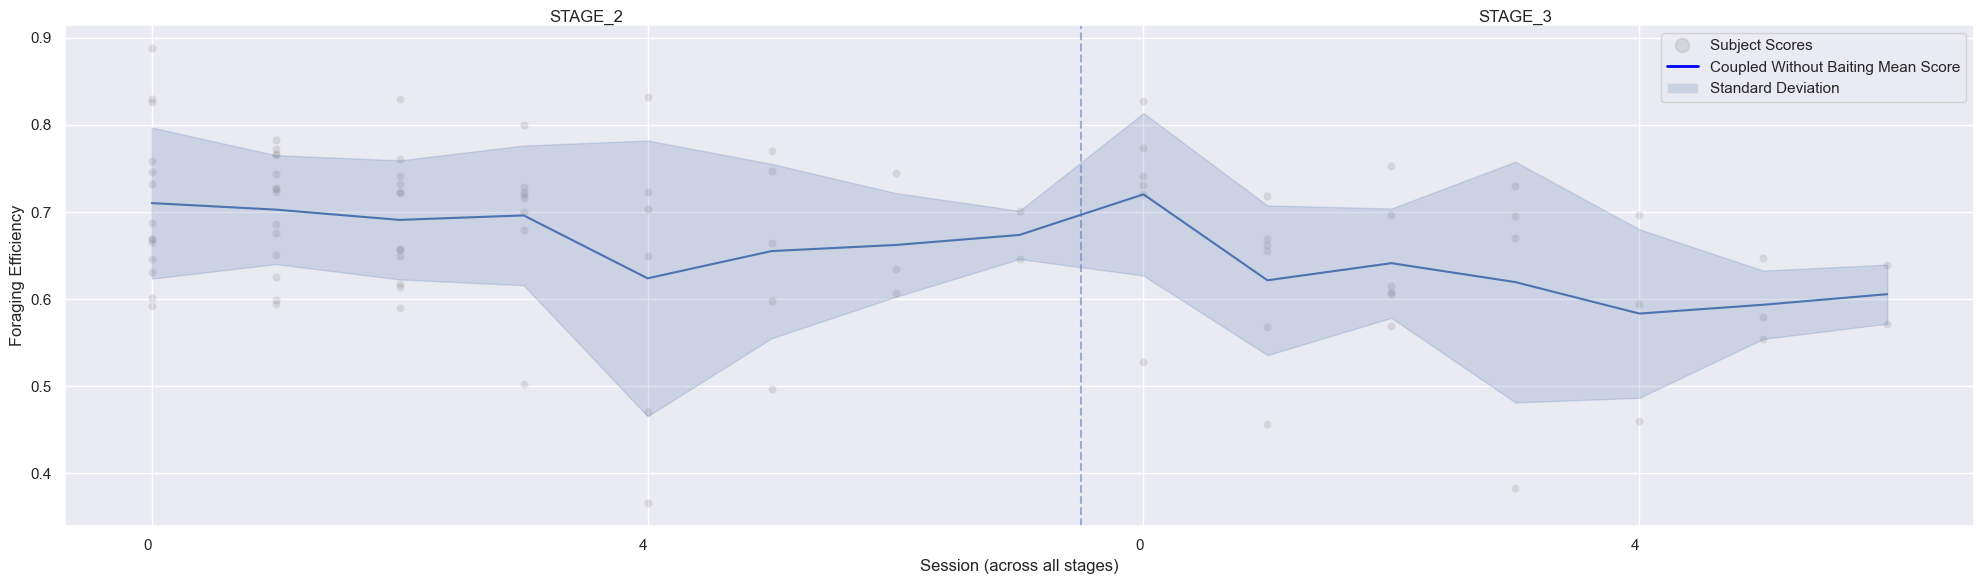


Statistics for Task: Coupled Without Baiting:

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.68
Standard deviation: 0.03
Min efficiency: 0.62
Max efficiency: 0.71

STAGE_3:
Number of Sessions: 7
Mean Foraging Efficiency: 0.63
Standard deviation: 0.05
Min efficiency: 0.58
Max efficiency: 0.72


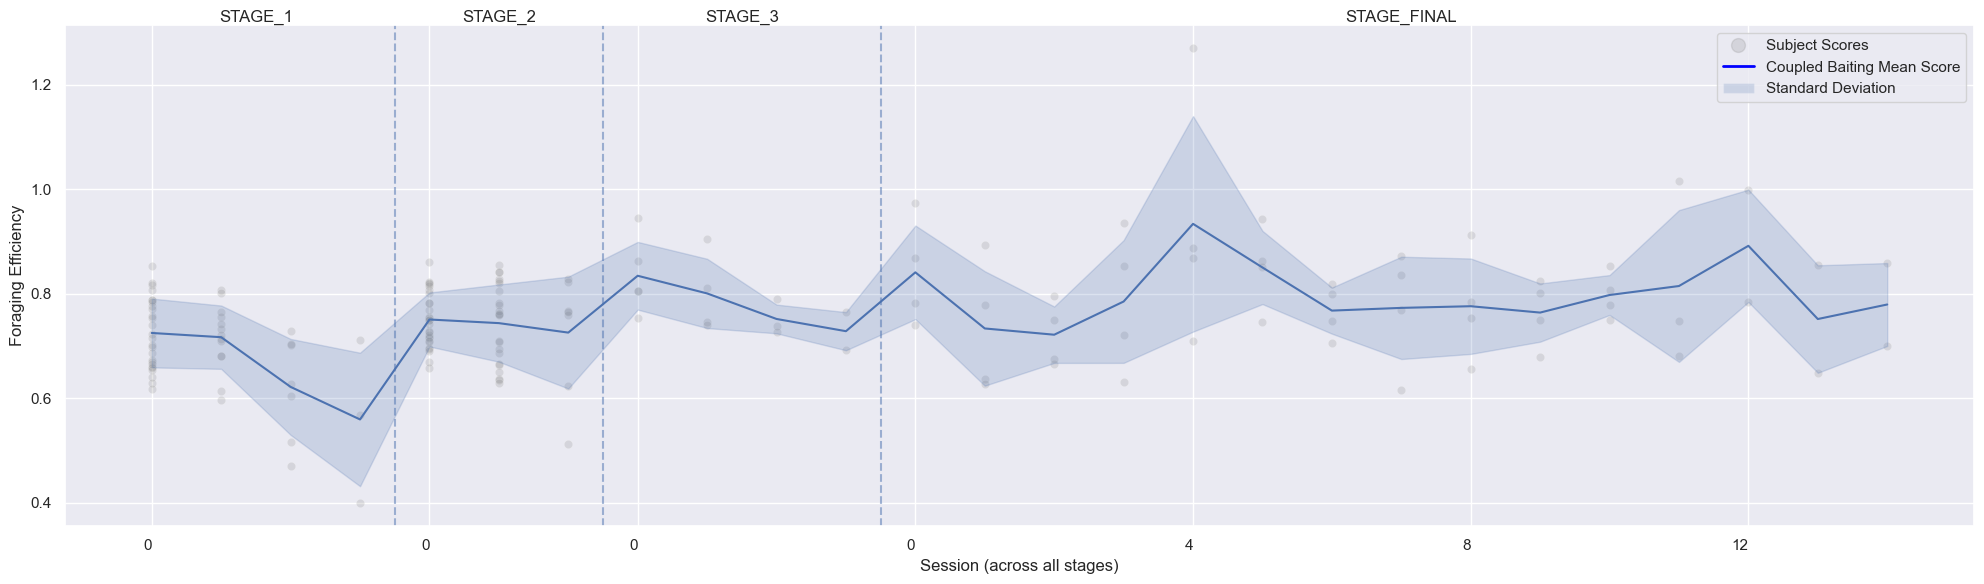


Statistics for Task: Coupled Baiting:

STAGE_1:
Number of Sessions: 4
Mean Foraging Efficiency: 0.66
Standard deviation: 0.08
Min efficiency: 0.56
Max efficiency: 0.72

STAGE_2:
Number of Sessions: 3
Mean Foraging Efficiency: 0.74
Standard deviation: 0.01
Min efficiency: 0.73
Max efficiency: 0.75

STAGE_3:
Number of Sessions: 4
Mean Foraging Efficiency: 0.78
Standard deviation: 0.05
Min efficiency: 0.73
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 15
Mean Foraging Efficiency: 0.80
Standard deviation: 0.06
Min efficiency: 0.72
Max efficiency: 0.93


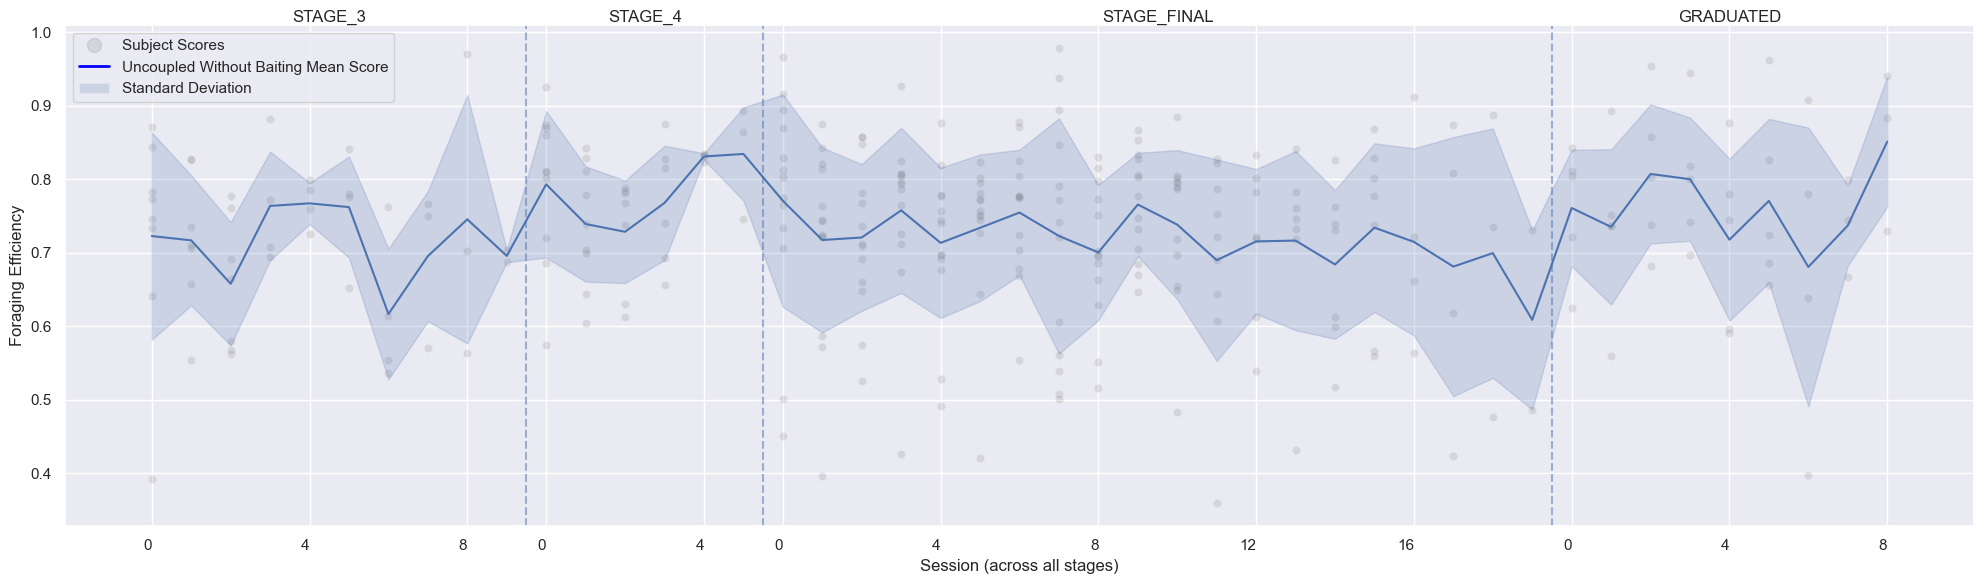


Statistics for Task: Uncoupled Without Baiting:

STAGE_3:
Number of Sessions: 10
Mean Foraging Efficiency: 0.71
Standard deviation: 0.05
Min efficiency: 0.62
Max efficiency: 0.77

STAGE_4:
Number of Sessions: 6
Mean Foraging Efficiency: 0.78
Standard deviation: 0.05
Min efficiency: 0.73
Max efficiency: 0.83

STAGE_FINAL:
Number of Sessions: 20
Mean Foraging Efficiency: 0.72
Standard deviation: 0.04
Min efficiency: 0.61
Max efficiency: 0.77

GRADUATED:
Number of Sessions: 9
Mean Foraging Efficiency: 0.76
Standard deviation: 0.05
Min efficiency: 0.68
Max efficiency: 0.85


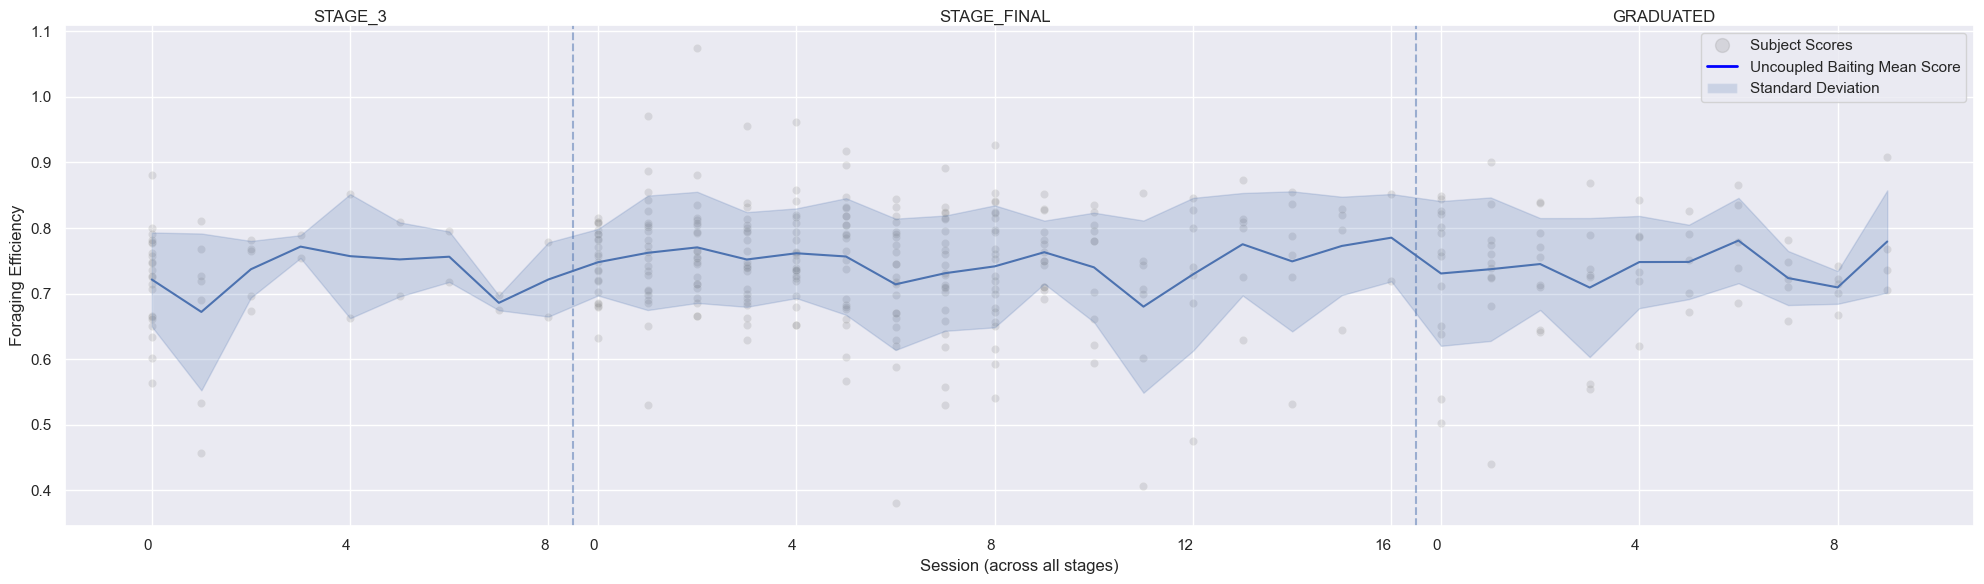


Statistics for Task: Uncoupled Baiting:

STAGE_3:
Number of Sessions: 9
Mean Foraging Efficiency: 0.73
Standard deviation: 0.03
Min efficiency: 0.67
Max efficiency: 0.77

STAGE_FINAL:
Number of Sessions: 17
Mean Foraging Efficiency: 0.75
Standard deviation: 0.03
Min efficiency: 0.68
Max efficiency: 0.79

GRADUATED:
Number of Sessions: 10
Mean Foraging Efficiency: 0.74
Standard deviation: 0.02
Min efficiency: 0.71
Max efficiency: 0.78


In [35]:
# Plot slow learners stage and task
au.plot_metric(slow_filtered_task_arrays, stage_vector)

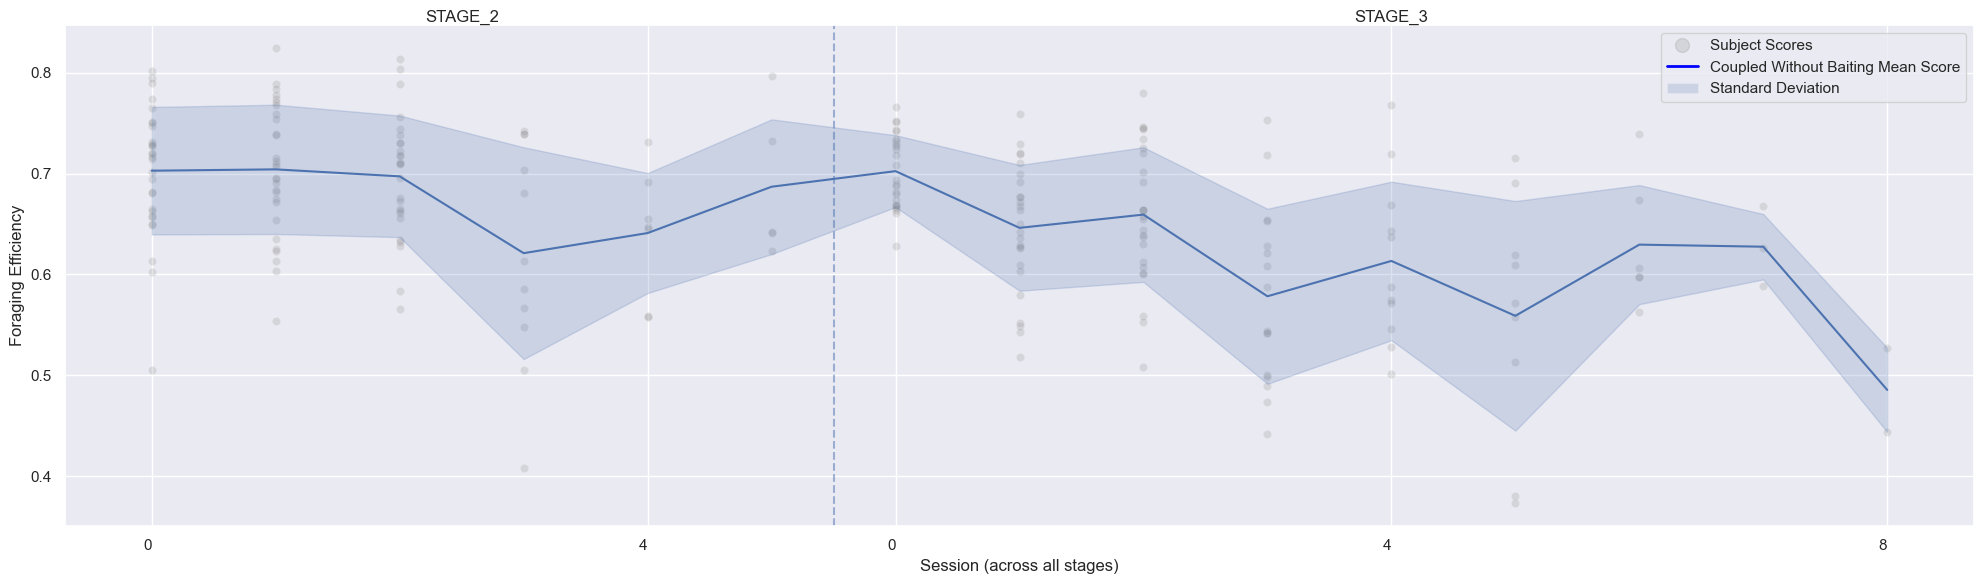


Statistics for Task: Coupled Without Baiting:

STAGE_2:
Number of Sessions: 6
Mean Foraging Efficiency: 0.68
Standard deviation: 0.04
Min efficiency: 0.62
Max efficiency: 0.70

STAGE_3:
Number of Sessions: 9
Mean Foraging Efficiency: 0.61
Standard deviation: 0.06
Min efficiency: 0.49
Max efficiency: 0.70


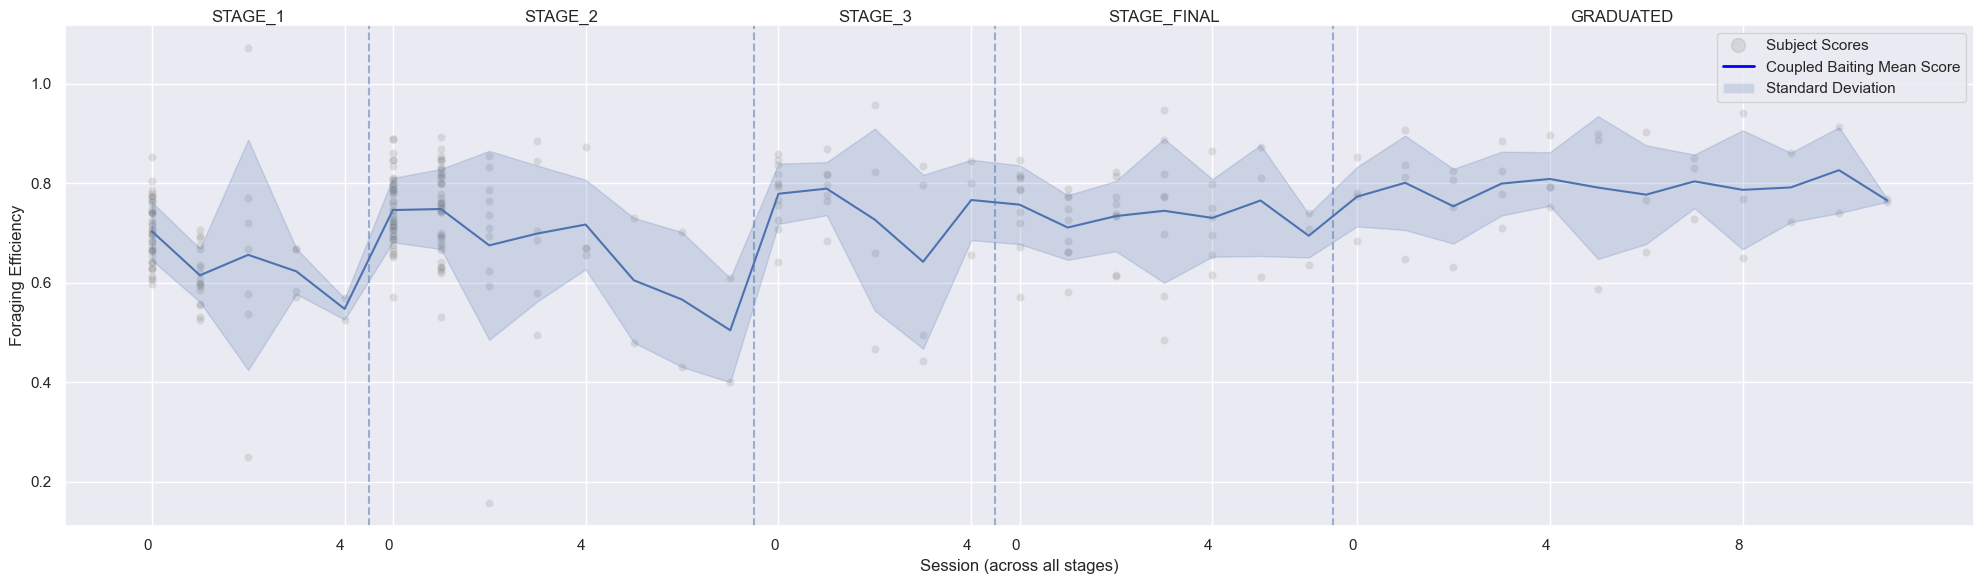


Statistics for Task: Coupled Baiting:

STAGE_1:
Number of Sessions: 5
Mean Foraging Efficiency: 0.63
Standard deviation: 0.06
Min efficiency: 0.55
Max efficiency: 0.70

STAGE_2:
Number of Sessions: 8
Mean Foraging Efficiency: 0.66
Standard deviation: 0.09
Min efficiency: 0.50
Max efficiency: 0.75

STAGE_3:
Number of Sessions: 5
Mean Foraging Efficiency: 0.74
Standard deviation: 0.06
Min efficiency: 0.64
Max efficiency: 0.79

STAGE_FINAL:
Number of Sessions: 7
Mean Foraging Efficiency: 0.73
Standard deviation: 0.02
Min efficiency: 0.69
Max efficiency: 0.77

GRADUATED:
Number of Sessions: 12
Mean Foraging Efficiency: 0.79
Standard deviation: 0.02
Min efficiency: 0.75
Max efficiency: 0.83


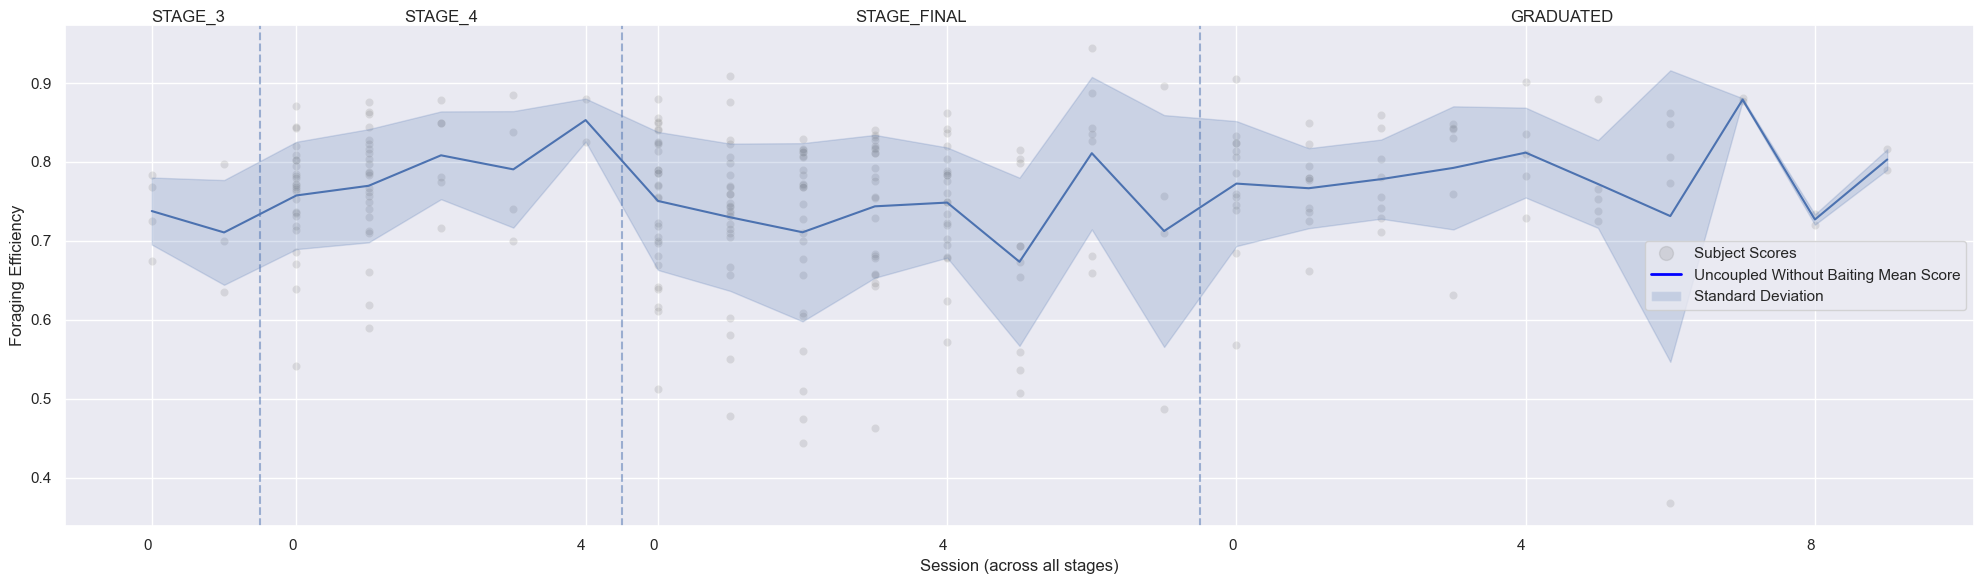


Statistics for Task: Uncoupled Without Baiting:

STAGE_3:
Number of Sessions: 2
Mean Foraging Efficiency: 0.72
Standard deviation: 0.02
Min efficiency: 0.71
Max efficiency: 0.74

STAGE_4:
Number of Sessions: 5
Mean Foraging Efficiency: 0.80
Standard deviation: 0.04
Min efficiency: 0.76
Max efficiency: 0.85

STAGE_FINAL:
Number of Sessions: 8
Mean Foraging Efficiency: 0.74
Standard deviation: 0.04
Min efficiency: 0.67
Max efficiency: 0.81

GRADUATED:
Number of Sessions: 10
Mean Foraging Efficiency: 0.78
Standard deviation: 0.04
Min efficiency: 0.73
Max efficiency: 0.88


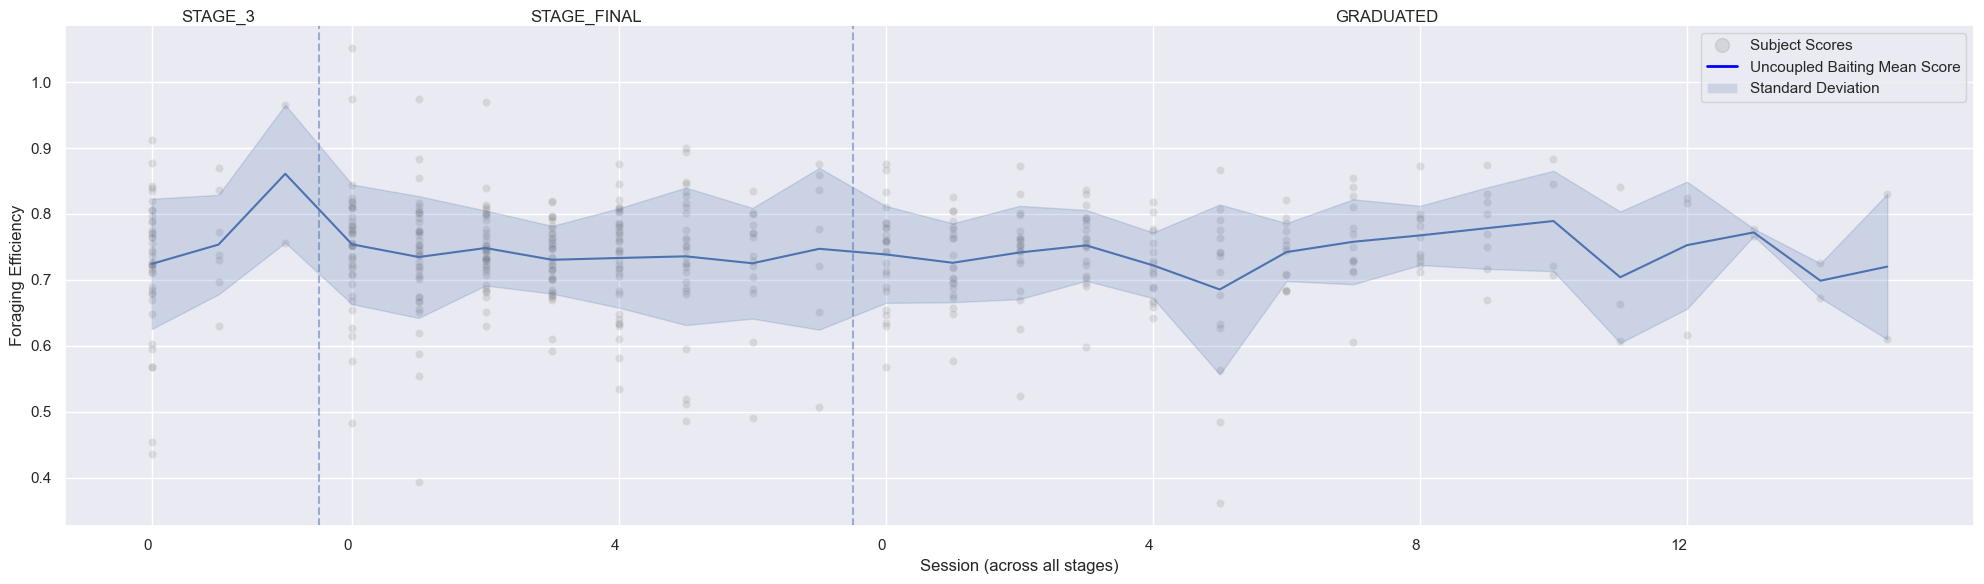


Statistics for Task: Uncoupled Baiting:

STAGE_3:
Number of Sessions: 3
Mean Foraging Efficiency: 0.78
Standard deviation: 0.07
Min efficiency: 0.72
Max efficiency: 0.86

STAGE_FINAL:
Number of Sessions: 8
Mean Foraging Efficiency: 0.74
Standard deviation: 0.01
Min efficiency: 0.73
Max efficiency: 0.75

GRADUATED:
Number of Sessions: 16
Mean Foraging Efficiency: 0.74
Standard deviation: 0.03
Min efficiency: 0.69
Max efficiency: 0.79


In [36]:

# Plot fast learners stage and task
au.plot_metric(fast_filtered_task_arrays, stage_vector)

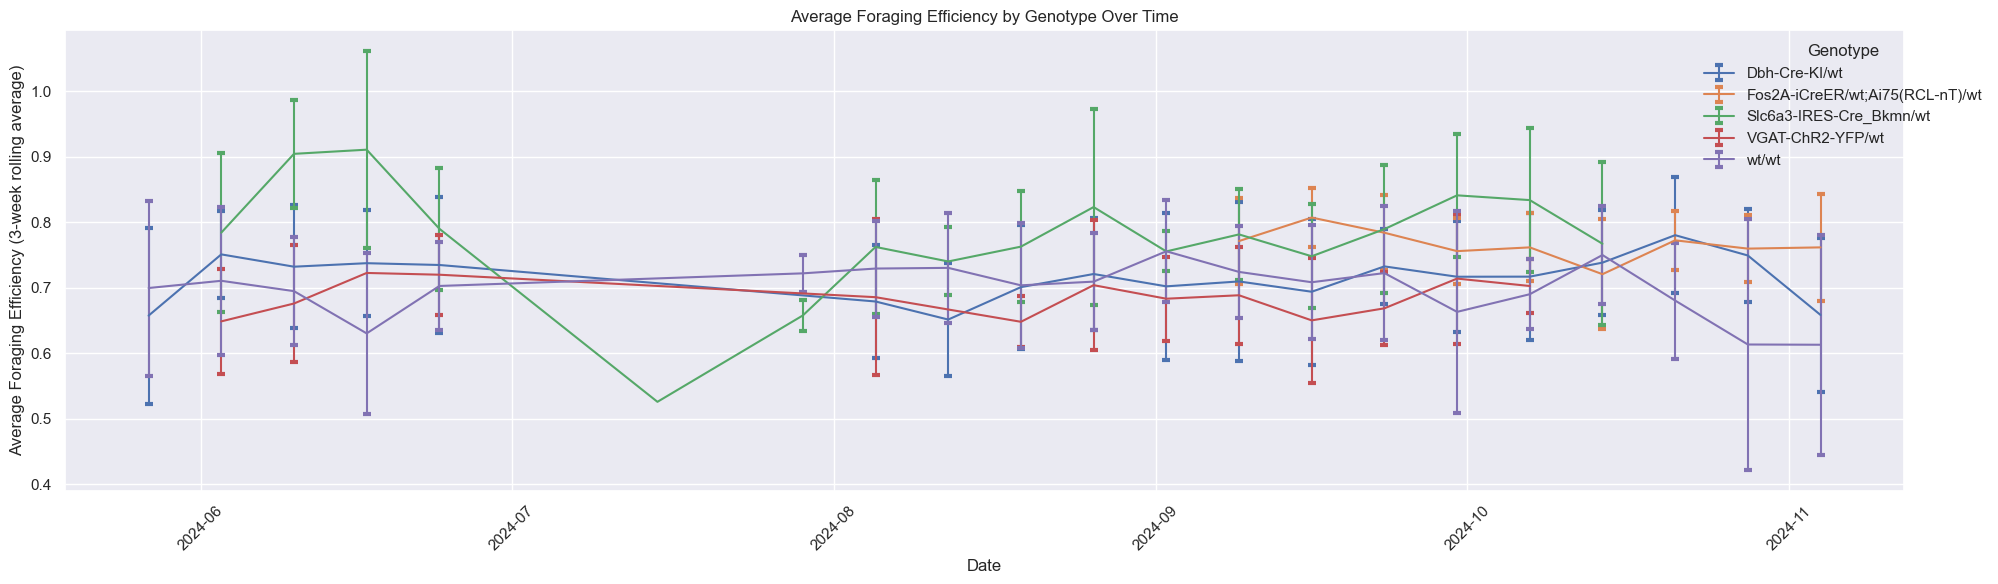

In [37]:
# Genotype plots

# Group by genotype and week
main_df['session_date'] = pd.to_datetime(df['session_date'], errors='coerce')
main_df['week'] = main_df['session_date'].dt.to_period('W')
grouped_df = main_df.groupby(['subject_genotype', 'week'])['foraging_eff'].agg(['mean', 'std']).reset_index() # Calculate mean foraging efficiency 
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()


# Take only top 5 most common genotypes in df
top_n_genotypes = main_df['subject_genotype'].value_counts().nlargest(5).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


# Plot dataframe
plt.figure(figsize=(20, 6))

# Plot average foraging efficiency for each genotype 
for genotype in grouped_df['subject_genotype'].unique():
    data = grouped_df[grouped_df['subject_genotype'] == genotype]
    plt.errorbar(data['week'], data['mean'], yerr=data['std'], label=genotype, capsize=3, capthick=3)

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon = False)

plt.tight_layout()
plt.show()

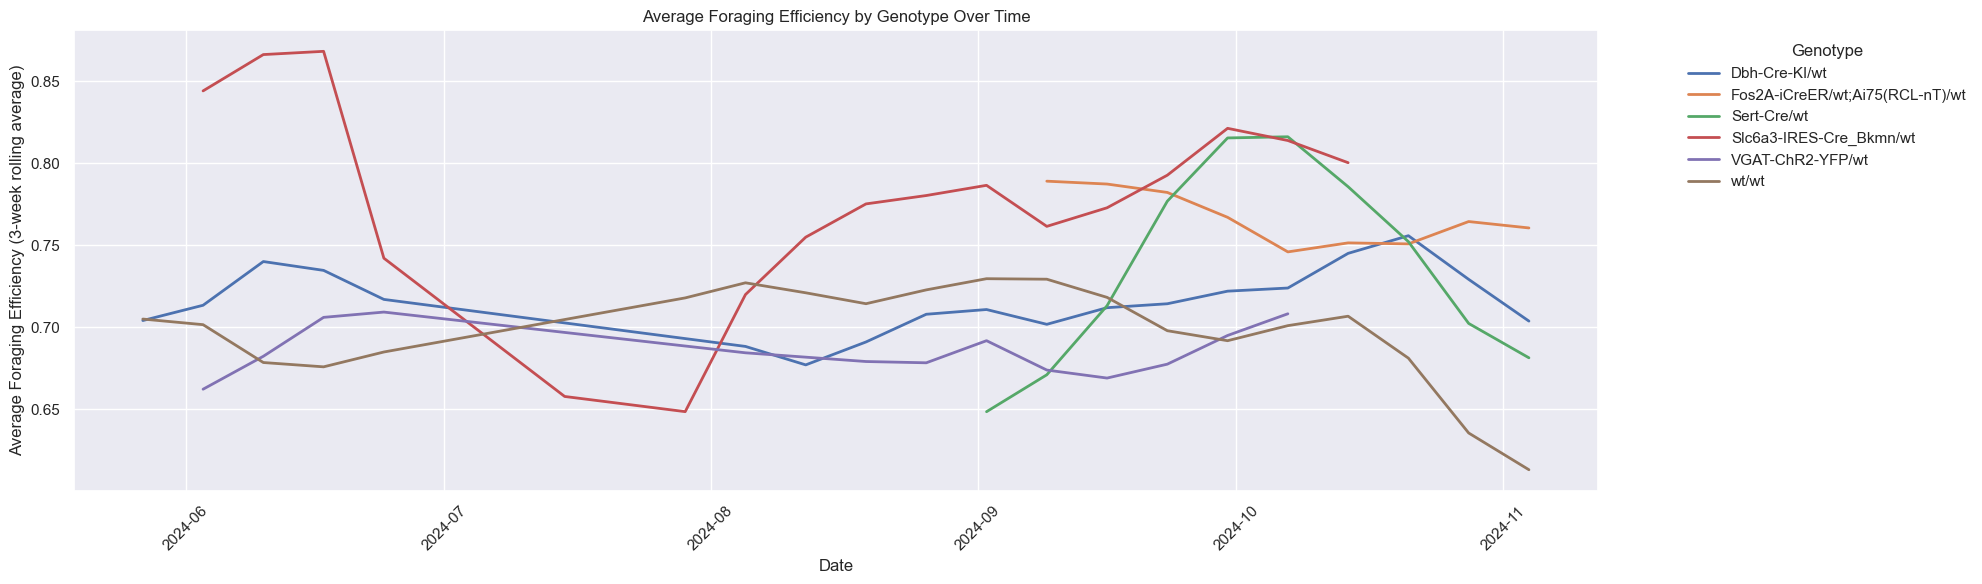

In [38]:
# Rolling average plot 

grouped_df = main_df.groupby(['subject_genotype', 'week'])['foraging_eff'].mean().reset_index()
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()

# Use 3 week rolling average
grouped_df = grouped_df.sort_values(['subject_genotype', 'week'])
grouped_df['rolling_avg'] = grouped_df.groupby('subject_genotype')['foraging_eff'].rolling(window=3, center=True, min_periods=1).mean().reset_index(0, drop=True)


top_n_genotypes = main_df['subject_genotype'].value_counts().nlargest(6).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


plt.figure(figsize=(20, 6))

sns.lineplot(data=grouped_df, x='week', y='rolling_avg', hue='subject_genotype', linewidth=2, errorbar='sd')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

plt.tight_layout()
plt.show()